In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  

from scipy.stats import skew
from scipy.stats.stats import pearsonr

In [5]:
train = pd.read_csv('../input/tcdml1920-income-ind/tcd ml 2019-20 income prediction training (with labels).csv')
test  = pd.read_csv('../input/tcdml1920-income-ind/tcd ml 2019-20 income prediction test (without labels).csv')

In [6]:
train.columns

Index(['Instance', 'Year of Record', 'Gender', 'Age', 'Country',
       'Size of City', 'Profession', 'University Degree', 'Wears Glasses',
       'Hair Color', 'Body Height [cm]', 'Income in EUR'],
      dtype='object')

In [7]:
train.rename(columns={ 'Body Height [cm]': 'Height' }, inplace=True)
test.rename(columns={ 'Body Height [cm]': 'Height' }, inplace=True)

train = train.replace({ 'Gender': { '0' : np.nan, 'unknown': np.nan } })
test  = test.replace({ 'Gender': { '0': np.nan , 'unknown': np.nan } })

train = train.replace({ 'University Degree': { '0' : np.nan, '#NaN': np.nan } })
test  = test.replace({ 'University Degree': { '0': np.nan, '#NaN': np.nan } })

train = train.replace({ 'Hair Color': { '0': np.nan, 'Unknown': np.nan } })
test = test.replace({ 'Hair Color': { '0': np.nan, 'Unknown': np.nan } })

In [8]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_percentage(train)

,Total,Percent
Gender,15005,13.40
University Degree,8067,7.20
Hair Color,7926,7.08
Age,494,0.44
Year of Record,441,0.39
Profession,322,0.29


In [6]:
# train.dropna(subset = ['Age', 'Year of Record', 'Profession'], inplace = True)
# test.dropna(subset = ['Age', 'Year of Record', 'Profession'], inplace = True)

In [7]:
# medians = train['Income in EUR'].groupby(train['Year of Record']).median()
# target_year_median = medians[2019]
# inflation = medians
# for item in medians.iteritems():
#     increase = target_year_median - item[1]
#     if increase == 0:
#         inflation[item[0]] = 0
#     else:
#         inflation[item[0]] = increase/item[1]

In [8]:
# train['Inflation'] = train.apply(lambda row: inflation[row['Year of Record']], axis=1) 
# test['Inflation'] = test.apply(lambda row: inflation[row['Year of Record']], axis=1) 

In [9]:
# train['New Income'] = train.apply(lambda row: row['Income in EUR'] + (row['Income in EUR'] * row['Inflation']), axis=1)

In [9]:
train['Year of Record'] = train['Year of Record'].fillna(np.rint(train['Year of Record'].mean()))
train['Year of Record'] = train['Year of Record'].astype('int32')
test['Year of Record'] = test['Year of Record'].fillna(np.rint(test['Year of Record'].mean()))
test['Year of Record'] = test['Year of Record'].astype('int32')

train['Age'] = train['Age'].fillna(np.rint(train['Age'].mean()))
train['Age'] = train['Age'].astype('int32')
test['Age'] = test['Age'].fillna(np.rint(test['Age'].mean()))
test['Age'] = test['Age'].astype('int32')

In [11]:
# train = train.loc[train['Income in EUR'] > 0]

all_data = pd.concat((train.loc[:, 'Year of Record': 'Height'],
                      test.loc[:, 'Year of Record': 'Height']))

#log transform the target:
log_income = np.log1p(train['Income in EUR'])
log_income = log_income.fillna(0)

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data, columns = ['Gender', 'Hair Color'])
all_data = all_data.fillna(all_data.mean())

X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = log_income

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log1p
  import sys


In [12]:
all_data.head()

,Year of Record,Age,Size of City,Wears Glasses,Height,Gender_female,Gender_male,Gender_other,Country_Afghanistan,Country_Albania,...,Profession_yardmaster,Profession_youth initiatives lead advisor,University Degree_Bachelor,University Degree_Master,University Degree_No,University Degree_PhD,Hair Color_Black,Hair Color_Blond,Hair Color_Brown,Hair Color_Red
0,1997,41,14.030566,0,193,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,1996,41,14.287702,0,186,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
2,2018,28,14.076349,1,170,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,2006,33,13.530364,1,171,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
4,2010,46,11.465729,0,188,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [ ]:
model_ridge = Ridge()

alphas = [-1, 0.001, 0.05, 0.1, 0.3, 1, 2, 3, 5]
cv_ridge = [rmse_cv(Ridge(alpha = alpha, normalize = True)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot()
plt.xlabel("alpha")
plt.ylabel("rmse")

In [15]:
alphas = [1, 0.1, 0.001, 0.0005]
model_lasso = LassoCV(alphas = alphas).fit(X_train, y)
rmse_cv(model_lasso).mean()

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt

0.4802691379754699

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


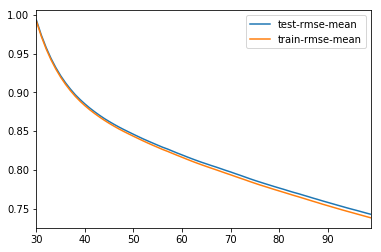

In [16]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = { 
    'max_depth': 3, 
    'eta': 0.1
}
model = xgb.cv(params, dtrain,  num_boost_round=100, early_stopping_rounds=8)

model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [17]:
model_xgb = xgb.XGBRegressor(n_estimators = 40, max_depth = 3, learning_rate = 0.95, subsample = 0.25)
model_xgb.fit(X_train, y)

[11:23:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.95, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=40,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.25, verbosity=1)

In [18]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

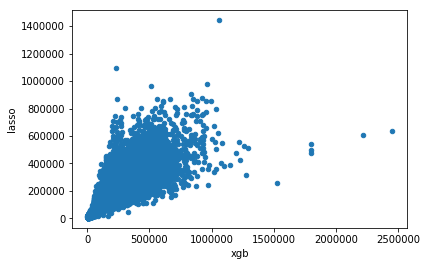

In [19]:
predictions = pd.DataFrame({ 'xgb': xgb_preds, 'lasso' :lasso_preds})
predictions.plot(x = 'xgb', y = 'lasso', kind = 'scatter')

In [20]:
preds = 0.7 * lasso_preds + 0.3 * xgb_preds
solution = pd.DataFrame({ 'Instance': test['Instance'], 'Income': preds})
solution.to_csv('ensemble_sol.csv', index = False)